In [1]:
import jax
jax.config.update('jax_default_device',jax.devices()[0])
jax.config.update('jax_enable_x64',True)
import equinox as eqx
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from jax import grad, vmap
import optax
from diffrax import (
    diffeqsolve, ODETerm, Dopri5, ControlTerm, 
    Euler, MultiTerm, ODETerm, SaveAt, VirtualBrownianTree, Heun,
    WeaklyDiagonalControlTerm,PIDController
)
from tqdm.auto import tqdm

from stochastic_interpolant.kernel_transport.rpc import lazy_pivoted_partial_cholesky
from stochastic_interpolant.kernel_transport.KernelTools import (
    get_gaussianRBF,vectorize_kfunc,
    get_sum_of_kernels,get_poly_kernel
)

from stochastic_interpolant.dataloaders import DatasetSampler, GaussianReferenceSampler, IndependenceCouplingSampler, build_trainloader, testloader_factory
from stochastic_interpolant.loss_functions import get_linear_interpolants, get_loss_functions, root_prod_gamma

from functools import partial
plt.style.use('ggplot')

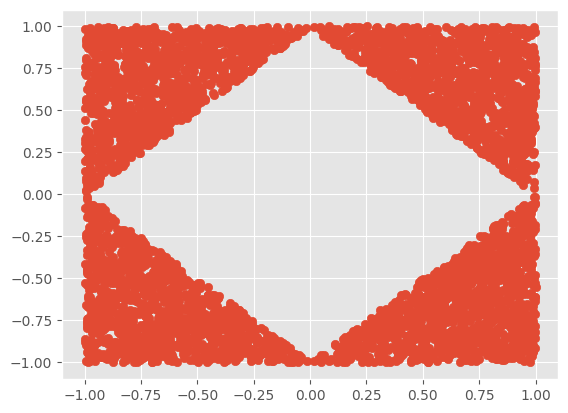

In [5]:
num_target = 5000
key = jax.random.PRNGKey(10)
target_samples = jax.random.uniform(key,shape = (10*num_target,2),minval=-1,maxval=1)
target_samples = 1 * target_samples[jnp.sum(jnp.abs(target_samples),1)>1.][:num_target]

num_reference = 10000
key = jax.random.PRNGKey(15)
reference_samples = jax.random.normal(key=key,shape=(num_reference,2))
plt.scatter(target_samples[:,0],target_samples[:,1])

In [6]:

I,It = get_linear_interpolants()

gamma = root_prod_gamma
gammadot = vmap(vmap(grad(gamma)))

def gamma(t):
    return 0.25 * jnp.sqrt(2*t*(1-t)+1e-8)

gammadot = vmap(vmap(grad(gamma)))


loss_b,loss_eta = get_loss_functions(I,It,gamma,gammadot)

data_coupling_sampler = IndependenceCouplingSampler(
    GaussianReferenceSampler((2,)),
    DatasetSampler(target_samples)
    )

In [7]:
from stochastic_interpolant.kernel_transport.ksi import KernelModel


k = get_sum_of_kernels([get_gaussianRBF(0.25),get_poly_kernel(deg = 4,c = 1)],[1,1])
b_model = KernelModel(3,2,k,num_anchors = 5000)
num_select_center = 40000
t,x,y,z = next(build_trainloader(num_select_center,jax.random.PRNGKey(124),data_coupling_sampler))
rpc_results = b_model.get_set_rpc_anchors(jnp.hstack([t,I(t,x,y)]),129)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [9]:
from stochastic_interpolant.loss_functions import loss_pieces
from stochastic_interpolant.kernel_transport.ksi import kernel_transport_loader
batch_size = 10000
num_batches = 100
train_loader = build_trainloader(batch_size,jax.random.PRNGKey(124),data_coupling_sampler)
test_factory = testloader_factory(batch_size,jax.random.PRNGKey(32498130),data_coupling_sampler)

XyLoader = kernel_transport_loader(train_loader,I,It,gamma,gammadot)
AtA,Atb = b_model.accumulate_system(XyLoader,num_batches)

  0%|          | 0/100 [00:00<?, ?it/s]

In [40]:
from kernel_code.KernelTools import diagpart
from stochastic_interpolant.model_training import evaluate_test_loss
from scipy.optimize import minimize_scalar

def reg_loss(alpha):
    coeffs = jnp.linalg.solve(AtA + 10**(-alpha) * diagpart(b_model.kmat),Atb)
    b_model.weights = coeffs
    return evaluate_test_loss(b_model,test_factory(),loss_b,20)

result = minimize_scalar(reg_loss,(-10,0.),method = 'brent',options = {'maxiter':2})
coeffs = jnp.linalg.solve(AtA + 10**(-result.x) * diagpart(b_model.kmat),Atb)
b_model.weights = coeffs

In [46]:
vmapped_b_model = vmap(b_model)
@eqx.filter_jit
def dX_t(t,x,args):
    t_vec = jnp.ones((len(x),1))*t
    return vmapped_b_model(jnp.hstack([t_vec,x]))

X0 = reference_samples.copy()
t0, t1 = 0.0,1.0

solver = Dopri5()
stepsize_controller = PIDController(rtol=1e-5, atol=1e-5)
#saveat = SaveAt(dense=True)

sol = diffeqsolve(ODETerm(dX_t), solver, t0, t1,dt0 = 0.01,  y0=X0,stepsize_controller = stepsize_controller)
#X = sol.evaluate(1.0)
#print(X)  

(-1.5, 1.5)

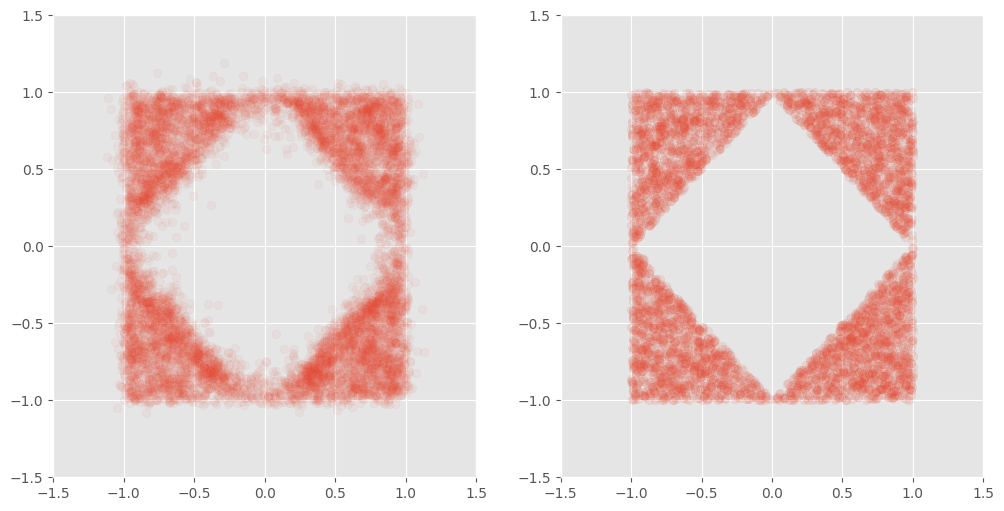

In [47]:
X = sol.ys[0]
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(X[:,0],X[:,1],alpha = 0.05)

lim = 1.5
plt.xlim(-lim,lim)
plt.ylim(-lim,lim)
plt.subplot(1,2,2)
plt.scatter(target_samples[:,0],target_samples[:,1],alpha = 0.1)
plt.xlim(-lim,lim)
plt.ylim(-lim,lim)